In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

C:\Users\milan\AppData\Local\Temp\ipykernel_19052\3757091537.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)



Using CAT Model with Monte Carlo Simulations to forecast...
CAT Model Forecast Results:
Probable Maximum Loss (PML) for 100-year return period: 10527.3 million USD
Forecasted Total Damage for Next Year: 803.04 million USD


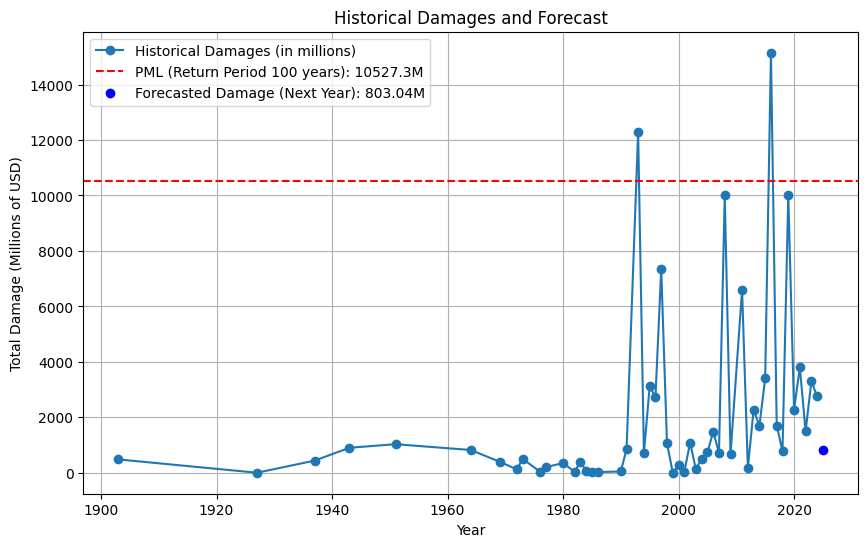

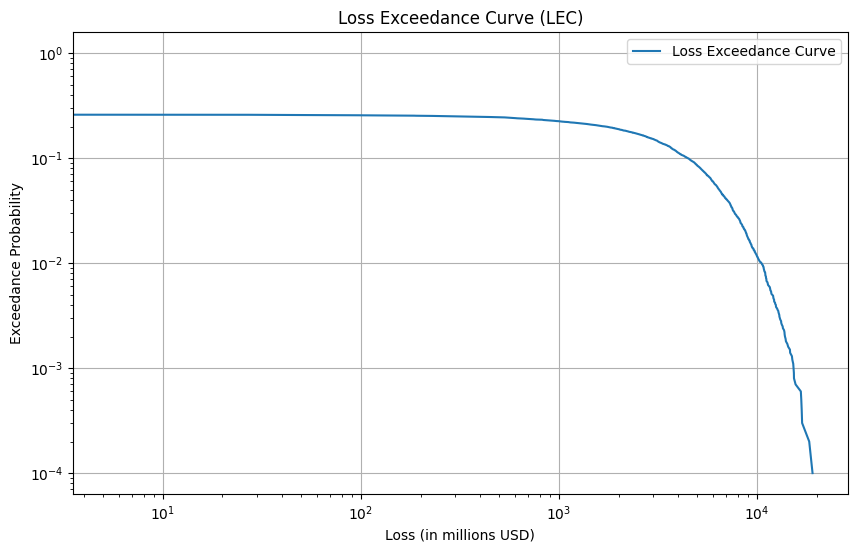

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm

# Load the Excel file containing the data
def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# Preprocessing function
def preprocess_data(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) &
                         (data['Disaster Type'] == disaster_type)]
    if filtered_data.empty:
        return None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    # Group by Year and sum the damage
    historical_data = filtered_data[['Year', "Total Damage ('000 US$)"]].dropna()
    historical_data = historical_data.groupby('Year', as_index=False).sum()
    historical_data['Total Damage (Millions)'] = historical_data["Total Damage ('000 US$)"] / 1_000
    historical_data.set_index('Year', inplace=True)
    return historical_data

# CAT model forecast function with Monte Carlo simulations
def simulate_cat_model(historical_data, num_simulations=10000, return_period=100):
    try:
        np.random.seed(21)  # Set seed for reproducibility

        # Calculate frequency and severity from historical data
        timespan = historical_data.index.max() - historical_data.index.min() + 1
        frequency = len(historical_data) / timespan  # Number of years with events divided by timespan
        severity_mean = historical_data['Total Damage (Millions)'].mean()
        severity_std = historical_data['Total Damage (Millions)'].std()

        # Simulate losses using Monte Carlo
        simulated_losses = []
        next_year_losses = []
        for i in range(num_simulations):
            num_events = poisson.rvs(frequency)
            total_loss = sum(norm.rvs(severity_mean, severity_std, size=num_events))
            simulated_losses.append(total_loss)

            # Simulate losses specifically for the next year
            if i < num_simulations // 10:
                next_year_loss = sum(norm.rvs(severity_mean, severity_std, size=num_events))
                next_year_losses.append(next_year_loss)

        # Sort losses to calculate Probable Maximum Loss (PML)
        simulated_losses.sort()
        pml_index = int((1 - 1 / return_period) * num_simulations)
        pml_value = simulated_losses[pml_index]

        # Calculate the mean forecast for the next year
        next_year_forecast = np.mean(next_year_losses)

        # Generate Loss Exceedance Curve (LEC)
        loss_exceedance = [(1 - i / num_simulations, loss) for i, loss in enumerate(simulated_losses)]

        return round(pml_value, 2), simulated_losses, round(next_year_forecast, 2), loss_exceedance
    except Exception as e:
        return f"CAT model simulation failed: {e}", None, None, None

# Plot function for CAT model with Monte Carlo
def plot_cat_model(historical_data, simulated_losses, pml_value, return_period, next_year_forecast, loss_exceedance):
    plt.figure(figsize=(10, 6))

    # Plot historical data
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], label="Historical Damages (in millions)", marker='o')

    # Highlight PML value
    plt.axhline(pml_value, color='red', linestyle='--', label=f"PML (Return Period {return_period} years): {pml_value}M")

    # Highlight next year forecast
    next_year = historical_data.index.max() + 1
    plt.scatter(next_year, next_year_forecast, color='blue', label=f"Forecasted Damage (Next Year): {next_year_forecast}M")

    plt.title("Historical Damages and Forecast")
    plt.xlabel("Year")
    plt.ylabel("Total Damage (Millions of USD)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Loss Exceedance Curve (LEC)
    exceedance_probabilities, losses = zip(*loss_exceedance)
    plt.figure(figsize=(10, 6))
    plt.plot(losses, exceedance_probabilities, label="Loss Exceedance Curve")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Loss Exceedance Curve (LEC)")
    plt.xlabel("Loss (in millions USD)")
    plt.ylabel("Exceedance Probability")
    plt.grid()
    plt.legend()
    plt.show()

# Forecast function using CAT model with Monte Carlo
def forecast_damage(data, country, disaster_type):
    historical_data = preprocess_data(data, country, disaster_type)
    if historical_data is None:
        print(f"No historical data available for {disaster_type} in {country}.")
        return

    print("\nUsing CAT Model with Monte Carlo Simulations to forecast...")

    # Simulate CAT model
    pml_value, simulated_losses, next_year_forecast, loss_exceedance = simulate_cat_model(historical_data)
    if isinstance(pml_value, str):
        print(pml_value)
        return

    print(f"CAT Model Forecast Results:")
    print(f"Probable Maximum Loss (PML) for 100-year return period: {pml_value} million USD")
    print(f"Forecasted Total Damage for Next Year: {next_year_forecast} million USD")

    plot_cat_model(historical_data, simulated_losses, pml_value, return_period=100, next_year_forecast=next_year_forecast, loss_exceedance=loss_exceedance)

# Main program
if __name__ == "__main__":
    file_path = "All Data.xlsx"
    data = load_data(file_path)
    if data is not None:
        country = input("Enter the country (ISO code, e.g., 'USA'): ").strip().upper()
        disaster_type = input("Enter the disaster type (e.g., 'Storm'): ").strip()
        forecast_damage(data, country, disaster_type)